In [29]:
import os, sys
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pickle

In [4]:
sys.version
plt.style.use("ggplot")
plt.rcParams["figure.figsize"] = (8,6)

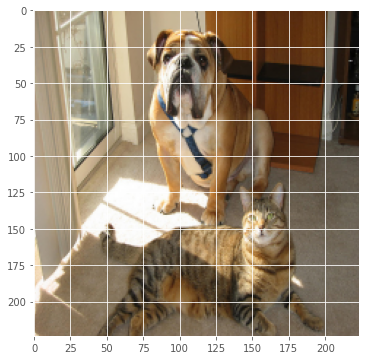

In [5]:
img = Image.open("../data/both.png").convert("RGB")
plt.imshow(img)

In [6]:
import json
with open("../data/imagenet_class_index.json", "r") as readfile:
    cls_idx = json.load(readfile)
    idx2label = [cls_idx[str(k)][1] for k in range(len(cls_idx))]

len(idx2label)

1000

In [7]:
import torch
import torch.nn as nn
from torchvision import models, transforms
import torch.nn.functional as F

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet50(pretrained=True)
model.eval()
model.to(device)

/home/a-tam/personal/LIME/.LIME-venv/lib/python3.6/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 6050). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  return torch._C._cuda_getDeviceCount() > 0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [9]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225])
])    


In [10]:
img_tensor = preprocess(img).unsqueeze(0).to(device)
img_tensor.shape

torch.Size([1, 3, 224, 224])

In [11]:
logits = model(img_tensor)
logits.shape

torch.Size([1, 1000])

In [12]:
probs = F.softmax(logits, dim=1)
probs.shape

torch.Size([1, 1000])

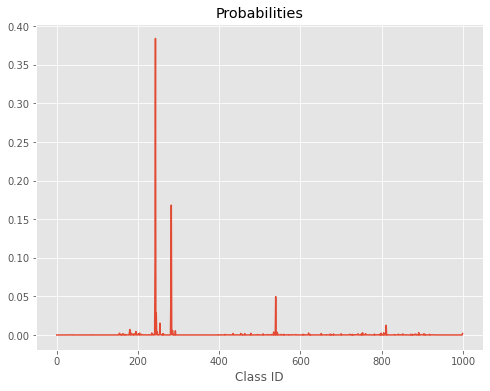

In [13]:
plt.title("Probabilities")
plt.xlabel("Class ID")
plt.plot(probs.detach().cpu().numpy()[0])

In [14]:
probs5 = probs.topk(5)
probability = probs5[0][0].detach().cpu().numpy()
class_id = probs5[1][0].detach().cpu().numpy()

probability, class_id

(array([0.38420382, 0.16826774, 0.09412272, 0.05912536, 0.04971128],
       dtype=float32),
 array([243, 282, 242, 281, 539]))

Text(0.5, 1.0, 'Predictions')

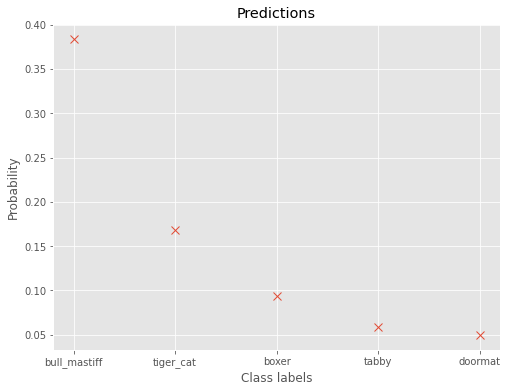

In [84]:
name = [idx2label[idx] for idx in class_id]
x = range(len(name)) 

plt.plot(probability, 'x', ms=8)
plt.xticks(x, name)
plt.xlabel("Class labels")
plt.ylabel("Probability")
plt.title("Predictions")

In [16]:
from lime.wrappers.scikit_image import SegmentationAlgorithm
from skimage.segmentation import mark_boundaries

78


/home/a-tam/personal/LIME/.LIME-venv/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


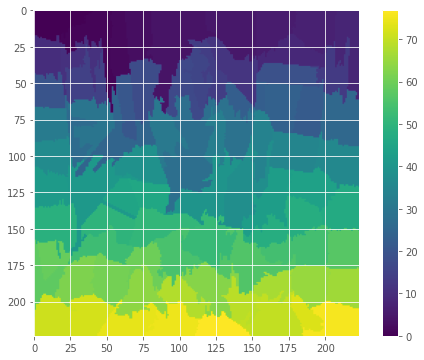

In [17]:
segmentation_fn = SegmentationAlgorithm(
    'slic',
    kernel_size=4,
    max_dist=200,
    ratio=0.2,
    random_seed=42
)

segments = segmentation_fn(img)

print(len(np.unique(segments)))

plt.imshow(segments)
plt.colorbar()

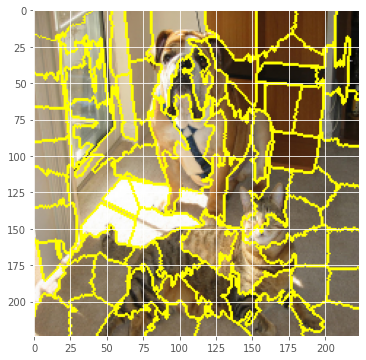

In [18]:
plt.imshow(mark_boundaries(np.array(img), segments))

In [19]:
def batch_predict(images):
    batch = torch.stack(tuple(preprocess(i) for i in images), dim=0)
    batch = batch.to(device)

    logits = model(batch)
    probs = F.softmax(logits, dim=1)
    return probs.detach().cpu().numpy()

In [20]:
from lime import lime_image

In [30]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
    np.array(img),
    batch_predict,
    top_labels = 2,
    hide_color = 0,
    num_samples = 5000,
    segmentation_fn = segmentation_fn
)

/home/a-tam/personal/LIME/.LIME-venv/lib/python3.6/site-packages/lime/wrappers/scikit_image.py:117: FutureWarning: skimage.measure.label's indexing starts from 0. In future version it will start from 1. To disable this warning, explicitely set the `start_label` parameter to 1.
  return self.target_fn(args[0], **self.target_params)


  0%|          | 0/5000 [00:00<?, ?it/s]

In [31]:
with open("../model/explanation.pkl", "wb") as exp:
    pickle.dump(explanation, exp)

In [32]:
for class_index in explanation.top_labels:
    class_label = idx2label[class_index]
    print(f"IDX: {class_index}\tLabel: {class_label}")

IDX: 243	Label: bull_mastiff
IDX: 282	Label: tiger_cat


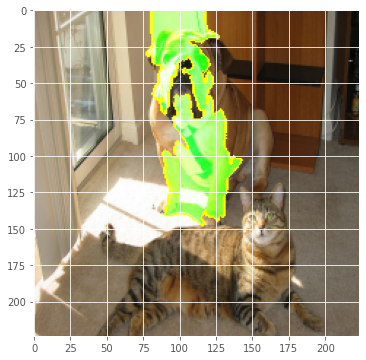

In [45]:
image, mask = explanation.get_image_and_mask(
    explanation.top_labels[0],
    positive_only = False,
    negative_only = False,
    num_features = 5,
    hide_rest = False
)

img_bound = mark_boundaries(image, mask)
plt.imshow(img_bound)

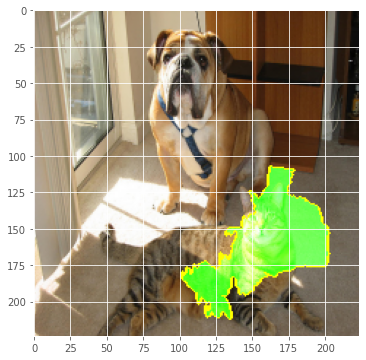

In [46]:
image, mask = explanation.get_image_and_mask(
    explanation.top_labels[1],
    positive_only = False,
    negative_only = False,
    num_features = 5,
    hide_rest = False
)

img_bound = mark_boundaries(image, mask)
plt.imshow(img_bound)

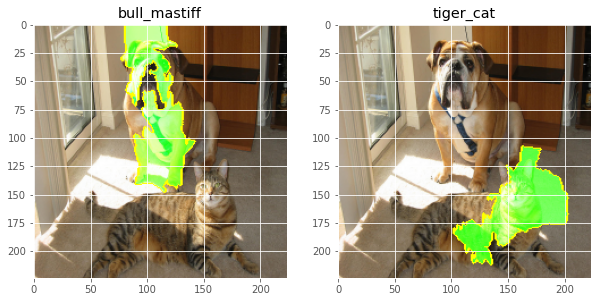

In [89]:
fig, ax = plt.subplots(1,2, figsize=(10,8))
ax = ax.ravel()
for i in range(2):
    image, mask = explanation.get_image_and_mask(
        explanation.top_labels[i],
        positive_only = False,
        negative_only = False,
        num_features = 5,
        hide_rest = False
    )

    img_bound = mark_boundaries(image, mask)
    
    ax[i].set_title(idx2label[explanation.top_labels[i]])
    ax[i].imshow(img_bound)

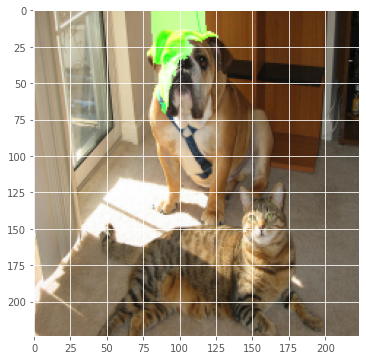

In [60]:
area_index, value = explanation.local_exp[explanation.top_labels[0]][0]
image = explanation.image.copy()
c = 0 if value < 0 else 1
image[segments == area_index, c] = np.max(image)
plt.imshow(image)

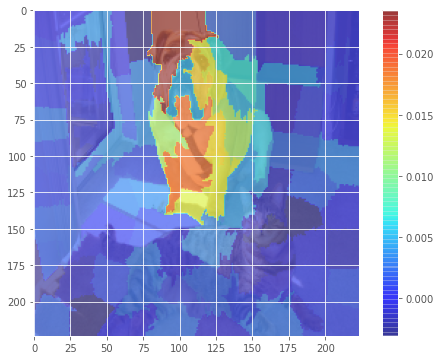

In [81]:
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[0]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(img, alpha=0.5)
plt.imshow(heatmap, alpha=0.5, cmap="jet")
plt.colorbar()
plt.title(idx2label[explanation.top_labels[0]])

Text(0.5, 1.0, 'tiger_cat')

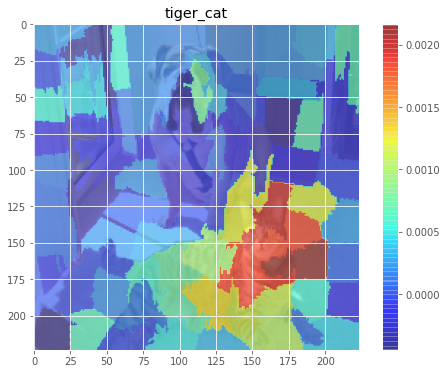

In [90]:
dict_heatmap = dict(explanation.local_exp[explanation.top_labels[1]])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments)

plt.imshow(img, alpha=0.5)
plt.imshow(heatmap, alpha=0.5, cmap="jet")
plt.title(idx2label[explanation.top_labels[1]])
plt.colorbar()